In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from src.autoencoders import Autoencoder, VariationalAutoEncoder
from utils.mnist_loader import data_download, data_loader
from utils.model_trainer import autoencoder_trainer, vae_trainer
from utils.visualization import visualization

In [2]:
def vae_loss(reconstruction, x, mu, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, x, reduction='sum') # bernoulli distribution assumption
    kl_loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss, kl_loss

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 100
SAMPLES = 5
BATCH_SIZE = 1024
LR = 5e-4
print(DEVICE)


cuda


In [4]:
train_data, test_data = data_download()
train_loader, test_loader = data_loader(train_data, test_data, batch_size=BATCH_SIZE)

number of training data :  60000
number of test data :  10000


# Beta-Variational Autoencoder

In [5]:
b_vae = VariationalAutoEncoder(n_hidden=336, z_dim=2).to(DEVICE)
optimizer = torch.optim.Adam(b_vae.parameters(), lr=LR)
criteria = vae_loss

In [6]:
train_loss, test_loss = vae_trainer(model=b_vae, beta=4,
                                    criteria=criteria, optimizer=optimizer, 
                                    train_loader=train_loader, test_loader=test_loader, 
                                    device=DEVICE, epochs = EPOCHS)

  1%|          | 1/100 [00:03<05:54,  3.58s/it]

epochs: 1 - Train loss: 239.84335327148438 - Test loss: 242.6012420654297
Test Error Ratio || reconstruction error: 222.7561798095703 , KLD: 4.961264610290527


 11%|█         | 11/100 [00:11<01:13,  1.21it/s]

epochs: 11 - Train loss: 189.9846649169922 - Test loss: 190.64230346679688
Test Error Ratio || reconstruction error: 183.5968017578125 , KLD: 1.761374592781067


 21%|██        | 21/100 [00:19<01:01,  1.28it/s]

epochs: 21 - Train loss: 177.55172729492188 - Test loss: 181.87464904785156
Test Error Ratio || reconstruction error: 170.68577575683594 , KLD: 2.79721736907959


 31%|███       | 31/100 [00:27<00:54,  1.26it/s]

epochs: 31 - Train loss: 177.756591796875 - Test loss: 178.4713592529297
Test Error Ratio || reconstruction error: 165.6561737060547 , KLD: 3.2037973403930664


 41%|████      | 41/100 [00:34<00:46,  1.28it/s]

epochs: 41 - Train loss: 169.12937927246094 - Test loss: 176.14132690429688
Test Error Ratio || reconstruction error: 162.33433532714844 , KLD: 3.451747179031372


 51%|█████     | 51/100 [00:42<00:41,  1.17it/s]

epochs: 51 - Train loss: 173.2347412109375 - Test loss: 174.22573852539062
Test Error Ratio || reconstruction error: 160.1349639892578 , KLD: 3.5226938724517822


 61%|██████    | 61/100 [00:50<00:30,  1.29it/s]

epochs: 61 - Train loss: 168.1346435546875 - Test loss: 170.6147003173828
Test Error Ratio || reconstruction error: 155.70217895507812 , KLD: 3.7281320095062256


 71%|███████   | 71/100 [00:58<00:23,  1.25it/s]

epochs: 71 - Train loss: 171.16419982910156 - Test loss: 170.32994079589844
Test Error Ratio || reconstruction error: 155.40682983398438 , KLD: 3.730778217315674


 81%|████████  | 81/100 [01:06<00:14,  1.28it/s]

epochs: 81 - Train loss: 167.3143768310547 - Test loss: 169.58448791503906
Test Error Ratio || reconstruction error: 154.0028533935547 , KLD: 3.8954086303710938


 91%|█████████ | 91/100 [01:14<00:07,  1.24it/s]

epochs: 91 - Train loss: 170.28622436523438 - Test loss: 169.0980987548828
Test Error Ratio || reconstruction error: 153.9007110595703 , KLD: 3.7993452548980713


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


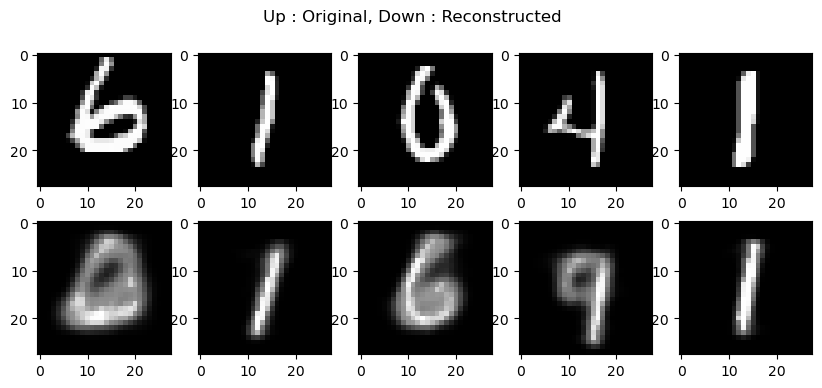

In [7]:
visualization(loader=test_loader, model=b_vae, device=DEVICE, num_of_samples=SAMPLES)

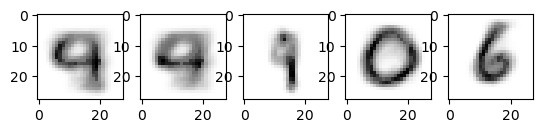

In [8]:
b_vae.cpu()
generated_samples = b_vae.generate(SAMPLES)

for i, sample in enumerate(generated_samples):
    plt.subplot(1, SAMPLES, i+1)
    plt.imshow(sample.reshape(28, 28), cmap='gray_r')
plt.show()

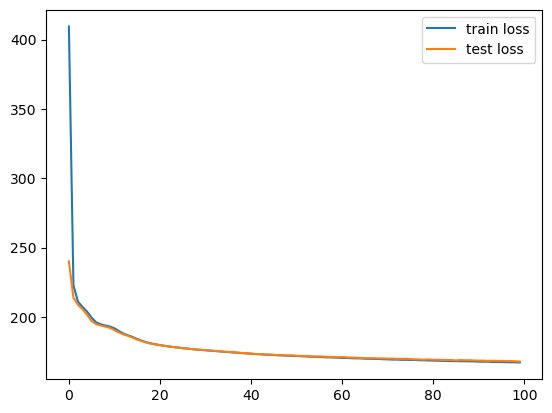

In [9]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label = 'test loss')
plt.legend()
plt.show()

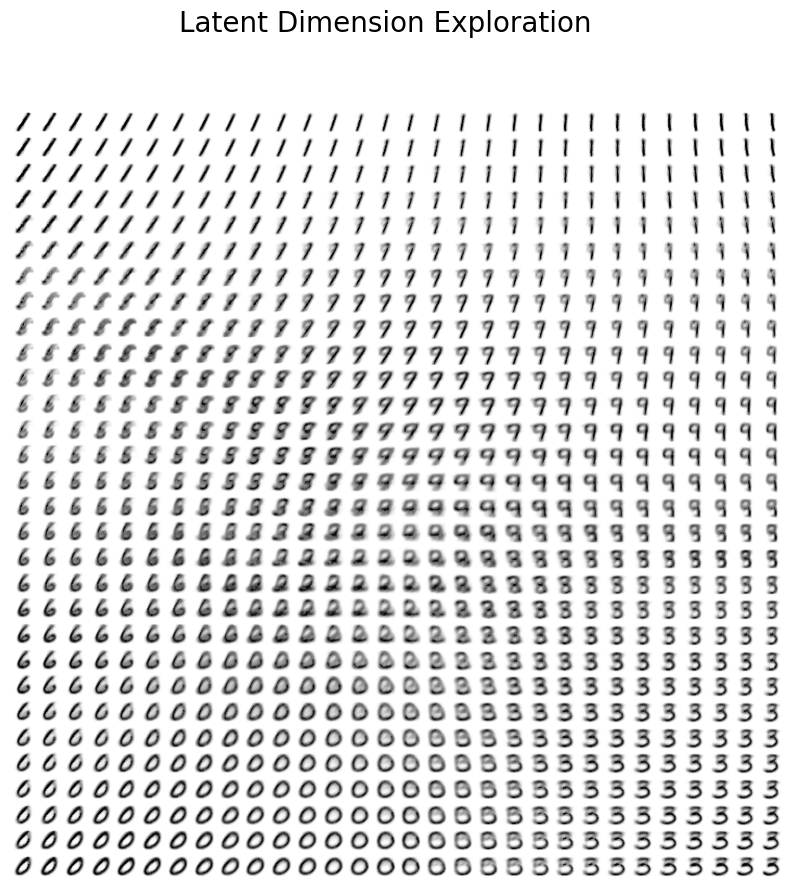

In [10]:
steps = 30
scope = 2.
xs = torch.linspace(scope, -scope, steps)
ys = torch.linspace(scope, -scope, steps)
x, y = torch.meshgrid(xs, ys, indexing='xy')
images = b_vae.decoder(torch.stack([x, y], dim=0).reshape(2, steps**2).T).view(-1, 28, 28)

fig = plt.figure(figsize=(10,10))
ax = [plt.subplot(steps, steps, i+1) for i in range(steps**2)]
for i, image in enumerate(images):
    ax[i].imshow(image.detach().numpy(), cmap='gray_r')
    ax[i].axis('off')
    ax[i].set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Latent Dimension Exploration',fontsize=20)
plt.show()


# CelebA Dataset

In [11]:
import torchvision
import torch

In [12]:
def vae_loss(reconstruction, x, mu, log_var):
    reconstruction_loss = nn.functional.mse_loss(reconstruction, x, reduction='sum') # gaussian distribution
    kl_loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss, kl_loss

In [13]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64,64), antialias=True)
])

celeb_dataset = torchvision.datasets.ImageFolder(
    root='../dataset/CelebA',
    transform=transform,
    target_transform=None
)

train_data, test_data = torch.utils.data.random_split(celeb_dataset, [len(celeb_dataset)-1024, 1024])
train_loader, test_loader = data_loader(train_data, test_data, batch_size=BATCH_SIZE)

### VAE

In [14]:
z_dim = 10

In [15]:
encoder = nn.Sequential(
    nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(32, 32, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(64, 64, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(64, 256, 4, 1), nn.ReLU(),
    nn.Flatten()
)

decoder = nn.Sequential(
    nn.Linear(z_dim, 256), nn.ReLU(),
    nn.Unflatten(-1, (256, 1, 1)),
    nn.ConvTranspose2d(256, 64, 4), nn.ReLU(),
    nn.ConvTranspose2d(64, 64, 4, 2, 1), nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
    nn.ConvTranspose2d(32, 32, 4, 2, 1), nn.ReLU(),
    nn.ConvTranspose2d(32, 3, 4, 2, 1) # bernoulli assumed
)

In [16]:
vae = VariationalAutoEncoder(encoder=encoder, decoder=decoder, n_hidden=256, z_dim=z_dim).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)
criteria = vae_loss

In [19]:
train_loss, test_loss = vae_trainer(model=vae, beta=1,
                                    criteria=criteria, optimizer=optimizer, 
                                    train_loader=train_loader, test_loader=test_loader, 
                                    device=DEVICE, epochs = EPOCHS)

  1%|          | 1/100 [00:17<28:51, 17.49s/it]

epochs: 1 - Train loss: 305.42840576171875 - Test loss: 306.3746032714844
Test Error Ratio || reconstruction error: 282.99249267578125 , KLD: 23.382104873657227


 11%|█         | 11/100 [03:17<28:02, 18.91s/it]

epochs: 11 - Train loss: 283.1849670410156 - Test loss: 290.77734375
Test Error Ratio || reconstruction error: 267.184814453125 , KLD: 23.592540740966797


 21%|██        | 21/100 [06:46<27:27, 20.86s/it]

epochs: 21 - Train loss: 289.1279602050781 - Test loss: 285.1296081542969
Test Error Ratio || reconstruction error: 261.3207092285156 , KLD: 23.80890655517578


 31%|███       | 31/100 [10:36<27:16, 23.72s/it]

epochs: 31 - Train loss: 288.400390625 - Test loss: 281.7407531738281
Test Error Ratio || reconstruction error: 257.74127197265625 , KLD: 23.999467849731445


 41%|████      | 41/100 [14:35<23:50, 24.25s/it]

epochs: 41 - Train loss: 277.3041687011719 - Test loss: 279.5179443359375
Test Error Ratio || reconstruction error: 255.62022399902344 , KLD: 23.897727966308594


 51%|█████     | 51/100 [18:35<19:26, 23.81s/it]

epochs: 51 - Train loss: 274.93310546875 - Test loss: 277.945068359375
Test Error Ratio || reconstruction error: 253.78277587890625 , KLD: 24.162288665771484


 61%|██████    | 61/100 [22:36<15:33, 23.93s/it]

epochs: 61 - Train loss: 274.65228271484375 - Test loss: 277.4748229980469
Test Error Ratio || reconstruction error: 253.47349548339844 , KLD: 24.001333236694336


 71%|███████   | 71/100 [26:38<11:49, 24.48s/it]

epochs: 71 - Train loss: 277.6357727050781 - Test loss: 276.59490966796875
Test Error Ratio || reconstruction error: 252.4039764404297 , KLD: 24.19091796875


 81%|████████  | 81/100 [30:47<07:53, 24.90s/it]

epochs: 81 - Train loss: 267.0913391113281 - Test loss: 275.16351318359375
Test Error Ratio || reconstruction error: 251.2097625732422 , KLD: 23.953746795654297


 91%|█████████ | 91/100 [34:52<03:43, 24.78s/it]

epochs: 91 - Train loss: 266.9111022949219 - Test loss: 273.7566223144531
Test Error Ratio || reconstruction error: 250.00730895996094 , KLD: 23.749324798583984


100%|██████████| 100/100 [38:38<00:00, 23.18s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


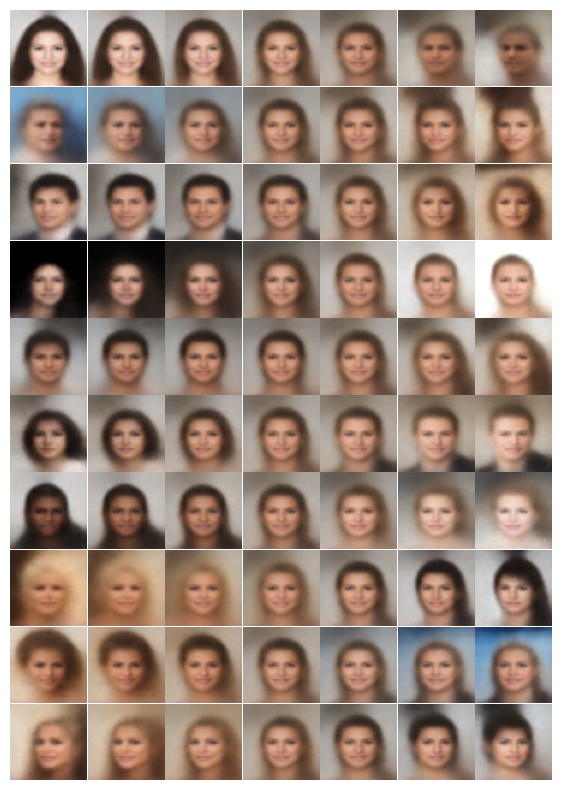

In [20]:
original = torch.rand(1,z_dim).to(DEVICE)
latents = original.shape[1]
steps = 7
linspace = torch.linspace(-3, 3, steps)
fig, axes = plt.subplots(latents, steps)
fig.set_figheight(latents)
fig.set_figwidth(steps)

for i in range(original.shape[1]):
    manipulated_latent = original.detach().clone()
    for j, new_val in enumerate(linspace):
        manipulated_latent[0, i] = new_val
        axes[i, j].imshow(vae.decoder(manipulated_latent)[0].detach().cpu().permute(1,2,0).numpy())
        axes[i, j].axis('off')
        axes[i, j].set_aspect('equal')
fig.subplots_adjust(wspace=0, hspace=0.01)
plt.show()

### b-VAE

In [26]:
encoder = nn.Sequential(
    nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(32, 32, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(64, 64, 4, 2, 1), nn.ReLU(),
    nn.Conv2d(64, 256, 4, 1), nn.ReLU(),
    nn.Flatten()
)

decoder = nn.Sequential(
    nn.Linear(z_dim, 256), nn.ReLU(),
    nn.Unflatten(-1, (256, 1, 1)),
    nn.ConvTranspose2d(256, 64, 4), nn.ReLU(),
    nn.ConvTranspose2d(64, 64, 4, 2, 1), nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
    nn.ConvTranspose2d(32, 32, 4, 2, 1), nn.ReLU(),
    nn.ConvTranspose2d(32, 3, 4, 2, 1) # bernoulli assumed
)

In [27]:
b_vae = VariationalAutoEncoder(encoder=encoder, decoder=decoder, n_hidden=256, z_dim=z_dim).to(DEVICE)
optimizer = torch.optim.Adam(b_vae.parameters(), lr=LR)
criteria = vae_loss

In [28]:
train_loss, test_loss = vae_trainer(model=b_vae, beta=20,
                                    criteria=criteria, optimizer=optimizer, 
                                    train_loader=train_loader, test_loader=test_loader, 
                                    device=DEVICE, epochs = EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:23<38:35, 23.39s/it]

epochs: 1 - Train loss: 654.6220703125 - Test loss: 676.03662109375
Test Error Ratio || reconstruction error: 621.05224609375 , KLD: 2.749220132827759


 11%|█         | 11/100 [04:24<35:17, 23.79s/it]

epochs: 11 - Train loss: 511.81671142578125 - Test loss: 522.5487060546875
Test Error Ratio || reconstruction error: 398.17559814453125 , KLD: 6.218655586242676


 21%|██        | 21/100 [08:28<31:54, 24.23s/it]

epochs: 21 - Train loss: 513.270751953125 - Test loss: 512.5152587890625
Test Error Ratio || reconstruction error: 378.1458435058594 , KLD: 6.718470573425293


 31%|███       | 31/100 [12:33<28:07, 24.45s/it]

epochs: 31 - Train loss: 511.30242919921875 - Test loss: 506.1101379394531
Test Error Ratio || reconstruction error: 365.6995849609375 , KLD: 7.0205278396606445


 41%|████      | 41/100 [16:38<23:23, 23.78s/it]

epochs: 41 - Train loss: 498.456298828125 - Test loss: 503.5739440917969
Test Error Ratio || reconstruction error: 362.2737121582031 , KLD: 7.065011978149414


 51%|█████     | 51/100 [20:45<20:16, 24.82s/it]

epochs: 51 - Train loss: 493.3034973144531 - Test loss: 501.8564758300781
Test Error Ratio || reconstruction error: 359.59161376953125 , KLD: 7.113243103027344


 61%|██████    | 61/100 [25:06<17:03, 26.25s/it]

epochs: 61 - Train loss: 497.50714111328125 - Test loss: 503.5357666015625
Test Error Ratio || reconstruction error: 364.34906005859375 , KLD: 6.9593353271484375


 71%|███████   | 71/100 [29:29<12:44, 26.37s/it]

epochs: 71 - Train loss: 494.91143798828125 - Test loss: 502.3887023925781
Test Error Ratio || reconstruction error: 360.00994873046875 , KLD: 7.118937969207764


 81%|████████  | 81/100 [33:47<08:12, 25.93s/it]

epochs: 81 - Train loss: 496.26873779296875 - Test loss: 501.23712158203125
Test Error Ratio || reconstruction error: 359.6748046875 , KLD: 7.078115463256836


 91%|█████████ | 91/100 [38:07<03:55, 26.12s/it]

epochs: 91 - Train loss: 501.094482421875 - Test loss: 503.13134765625
Test Error Ratio || reconstruction error: 359.9818115234375 , KLD: 7.15747594833374


100%|██████████| 100/100 [41:58<00:00, 25.19s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


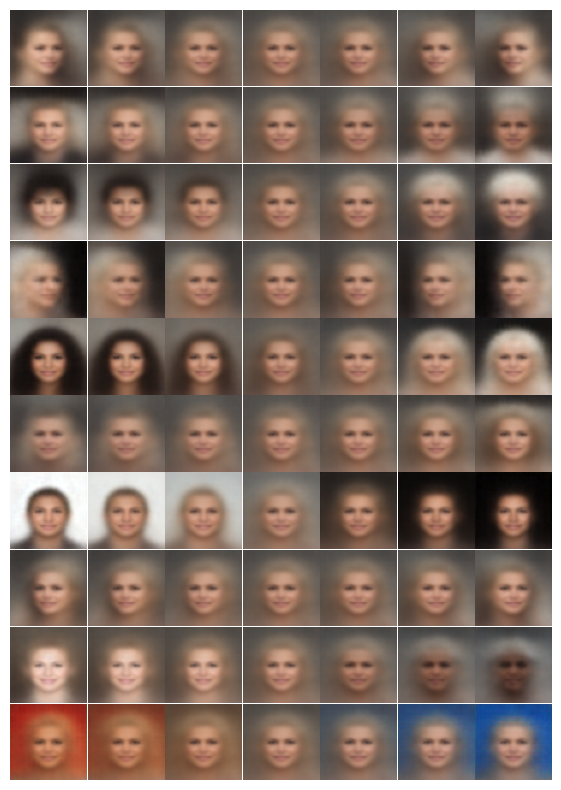

In [31]:
original = torch.rand(1,z_dim).to(DEVICE)
latents = original.shape[1]
steps = 7
linspace = torch.linspace(-3, 3, steps)
fig, axes = plt.subplots(latents, steps)
fig.set_figheight(latents)
fig.set_figwidth(steps)

for i in range(original.shape[1]):
    manipulated_latent = original.detach().clone()
    for j, new_val in enumerate(linspace):
        manipulated_latent[0, i] = new_val
        axes[i, j].imshow(b_vae.decoder(manipulated_latent)[0].detach().cpu().permute(1,2,0).numpy())
        axes[i, j].axis('off')
        axes[i, j].set_aspect('equal')
fig.subplots_adjust(wspace=0, hspace=0.01)
plt.show()